### Imports

Let's firstly load needed libraries for our analysis:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00


In [49]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
import time
warnings.filterwarnings('ignore')

We will use the following device for running our BERT model (using Colab Pro):

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(device))

Using device: NVIDIA A100-SXM4-40GB


### Data loading and preparation for BERT model

Let's load our train SNLI dataset:

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/ml-project-data-try/snli-preprocessed/snli_data_train.csv")
train_df = train_df.dropna().reset_index(drop=True)
train_df.head()

,label,premise,hypothesis
0,neutral,person horse jumps broken airplane,person training horse competition
1,contradiction,person horse jumps broken airplane,person diner ordering omelette
2,entailment,person horse jumps broken airplane,person outdoors horse
3,neutral,children smiling waving camera,smiling parents
4,entailment,children smiling waving camera,children present


Let's load our validation SNLI dataset:

In [8]:
val_df = pd.read_csv("/content/drive/MyDrive/ml-project-data-try/snli-preprocessed/snli_data_val.csv")
val_df = val_df.dropna().reset_index(drop=True)
val_df.head()

,label,premise,hypothesis
0,neutral,two women embracing holding go packages,sisters hugging goodbye holding go packages ea...
1,entailment,two women embracing holding go packages,two woman holding packages
2,contradiction,two women embracing holding go packages,men fighting outside deli
3,entailment,two young children blue jerseys one number nin...,two kids numbered jerseys wash hands
4,neutral,two young children blue jerseys one number nin...,two kids ballgame wash hands


In [13]:
train_df = train_df[(train_df['premise'].str.split().str.len() > 0) & (train_df['hypothesis'].str.split().str.len() > 0)]
val_df = val_df[(val_df['premise'].str.split().str.len() > 0) & (val_df['hypothesis'].str.split().str.len() > 0)]

Let's define a function where we can preprocess data for BERT model ( we need to create a DataLoader object to feed data to the model). BERT requires the data to be arranged in a certain format, where each sentence's start needs to have a `[CLS]` token present, and the end of the sentence needs a `[SEP]` token). Moreover, we need token_ids, attention_mask_ids, and segment_ids (which are certain data needed specificaly for BERT). Let's do this:

In [15]:
class SNLIDataBert(Dataset):
  def __init__(self, train_df, val_df):
    self.label_dict = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    self.train_data = self.load_data(train_df)
    self.val_data = self.load_data(val_df)

  def load_data(self, df):
    token_ids, mask_ids, seg_ids, y = [], [], [], []
    premise_list = df['premise'].to_list()
    hypothesis_list = df['hypothesis'].to_list()
    label_list = df['label'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]

      segment_ids = torch.tensor([0] * (len(premise_id) + 2) + [1] * (len(hypothesis_id) + 1))
      attention_mask_ids = torch.tensor([1] * (len(premise_id) + len(hypothesis_id) + 3))

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    return TensorDataset(token_ids, mask_ids, seg_ids, y)

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(self.train_data, shuffle=shuffle, batch_size=batch_size)
    val_loader = DataLoader(self.val_data, shuffle=shuffle, batch_size=batch_size)
    return train_loader, val_loader

Now let's get create our DataLoader objects for the training and validation sets.

In [16]:
snli_dataset = SNLIDataBert(train_df, val_df)

In [17]:
train_loader, val_loader = snli_dataset.get_data_loaders(batch_size=16)

We will use the BertForSequenceClassification pre-trained model, which is has an argument to add an optional classification head with the required number of labels. For this case, there are three classes (entailment, contradiction, and neutral).

In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

We will use Adam optimizer as it is a popular one for DL models and it is suitable for our model

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

The next variable contains all of the hyperparemeter information our training loop needs

In [26]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

See how many parameters our BERT model has:

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,484,547 trainable parameters


Defining accuracy function for our model

In [28]:
def multi_accuracy(y_pred, y_test):
  accuracy = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return accuracy

Now that the model is loaded, time to move to the training and validation loops. As part of the training process, the model was trained for 3 epochs for start as it is very computationaly expensive. The training process will return the trained model and various statistics, including the training and validation accuracy and loss for each epoch.

In [34]:
def train(model, train_loader, val_loader, optimizer, device, num_epochs):  
  best_val_acc = 0.0
  train_accuracy, train_loss = [], []
  validation_accuracy, validation_loss = [], []

  for epoch in range(num_epochs):
    print(f"Start of epoch {epoch+1}")
    start = time.time()
    model.train()
    total_train_loss, total_val_loss = 0.0, 0.0
    total_train_acc, total_val_acc  = 0.0, 0.0

    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      # Clear out the gradients
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      optimizer.zero_grad()
      # Forward pass
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
      
      train_loss.append(loss.item())    
      acc = multi_accuracy(prediction, labels)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc += acc.item()

    acc_train = total_train_acc / len(train_loader)
    loss_train = total_train_loss / len(train_loader)

    model.eval()

    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_accuracy(prediction, labels)
        total_val_loss += loss.item()
        total_val_acc += acc.item()

    val_acc = total_val_acc / len(val_loader)
    val_loss = total_val_loss / len(val_loader)
    
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save(model.state_dict(),'/content/drive/MyDrive/ml-project-data-try/bert_files/bert-snli.pt') 

    train_accuracy.append(acc_train)
    train_loss.append(loss_train)
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {loss_train:.4f} train_acc: {acc_train:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f"Best validation accuracy: {best_val_acc:.4f}")

  model_stats = {"train_accuracy": train_accuracy,
                  "train_loss": train_loss,
                  "validation_accuracy": validation_accuracy,
                  "validation_loss": validation_loss}
  return model, model_stats

Let's train our model and see what is our result!

In [35]:
model, model_stats = train(model, train_loader, val_loader, optimizer, device, num_epochs=3)
model

Start of epoch 1
Epoch 1: train_loss: 0.3442 train_acc: 0.8761 | val_loss: 0.3406 val_acc: 0.8799
00:30:48.63
Best validation accuracy: 0.8799
Start of epoch 2
Epoch 2: train_loss: 0.2814 train_acc: 0.9014 | val_loss: 0.3404 val_acc: 0.8849
00:31:19.96
Best validation accuracy: 0.8849
Start of epoch 3
Epoch 3: train_loss: 0.2332 train_acc: 0.9198 | val_loss: 0.3778 val_acc: 0.8836
00:31:25.50
Best validation accuracy: 0.8849


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

And we have the results of the best model! It is during epoch 2 and the statistics are the following:

Epoch 2:
- train_loss: 0.2814
- train_acc: 0.9014
- val_loss: 0.3404
- val_acc: 0.8849
- time taken for epoch: 00:31:19.96
- Best validation accuracy: 0.8849

Let's plot our overall performance of the model (history) during 3 epochs

In [56]:
def plot_accuracy_and_loss_graphs(stats):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(stats['train_accuracy'])
    plt.plot(stats['validation_accuracy'])
    plt.title("Accuracy")
    plt.xlabel('epoch')
    plt.xticks(range(3))
    plt.ylabel('accuracy')
    plt.legend(['train','validation'])

    plt.subplot(1,2,2)
    plt.plot(stats['train_loss'])
    plt.plot(stats['validation_loss'])
    plt.title("Loss")
    plt.xlabel('epoch')
    plt.xticks(range(3))
    plt.ylabel('loss')
    plt.legend(['train','validation'])

    plt.show()

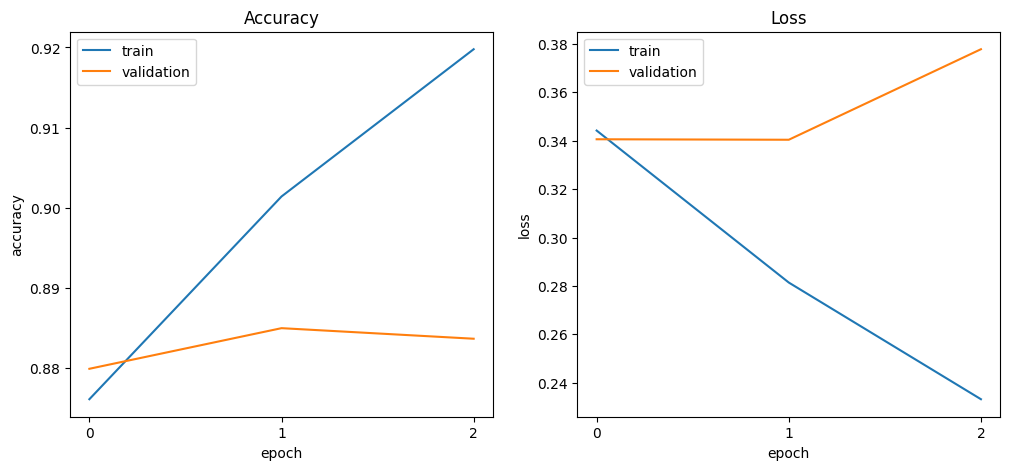

In [55]:
plot_accuracy_and_loss_graphs(model_stats)

From the plots above we can see the history of performance of our BERT model. It is not that much informative as we only had 3 epochs, but still we got nice results for loss and accuracy metrics during this time!

The BERT model achieved a validation accuracy of approximately 0.9 after 3 epochs of training, which is a really good result considering the limited number of epochs. Training a model on large datasets such as this can be computationally intensive and time-consuming (which was our case, but we used more powerfull GPU). 

Overall, these results suggest that the BERT model is a promising approach for our NLI task! We also saved the model to needed path, thus we can reuse it in the future:)